In [1]:
import numpy as np
import pandas as pd
import csv
from collections import defaultdict

# String data

### Build PPI network

In [2]:
nodes = []
node1=[]
node2=[]
weights=[]
with open('STRING-scores.txt','r') as f:
    next(f)
    reader=csv.reader(f,delimiter='\t')
    for n1, n2, w in reader:
        node1.append(n1)
        node2.append(n2)
        weights.append(1/float(w)) # inverse confidence: shorter "distance" when more confident
        
        if n1 not in nodes:
            nodes.append(n1)
        if n2 not in nodes:
            nodes.append(n2)

In [3]:
class Edge:
    def __init__(self, dest, weight):
        self.dest = dest
        self.weight = weight
    def __repr__(self):
        return self.dest + ": " + str(self.weight)

In [4]:
net = defaultdict(list)
for i in range(len(node1)):
    # add corresponding edge for both nodes
    e1 = Edge(node2[i], weights[i])
    net[node1[i]].append(e1)
        
    e2 = Edge(node1[i], weights[i])
    net[node2[i]].append(e2)

In [5]:
def printEdges(node):
    for e in node:
        print(e.dest + ': ' + str(e.weight))

In [6]:
printEdges(net['RRM1'])

ATR: 1.2150668286755772
CMPK1: 1.0775862068965516


In [7]:
for edge in net['RRM1']:
    dest = edge.dest
    print(dest)

ATR
CMPK1


### Path search for interaction scores

In [8]:
def dijkstra(graph, source):
    Q = []                # unvisited nodes
    dist = {}
    prev = {}             # only necessary for tracking paths - not used so far
    
    for node in graph:
        dist[node] = float('inf')
        prev[node] = None
        Q.append(node)
        
    dist[source] = 0      # distance from source to itself is 0
    
    while len(Q) > 0:
        current = Q[0]
        for node in Q:
            if dist[node] < dist[current]:
                current = node                # select node with shortest distance; source will be first
        Q.remove(current)
        
        for edge in graph[current]:
            dest = edge.dest
            
            alt = dist[current] + edge.weight  # new weight: total so far + edge weight
            if alt < dist[dest]:               # if new weight < old weight to this neighbor
                dist[dest] = alt
                prev[dest] = current
                
    return dist

In [9]:
print(dijkstra(net, 'ATR'))

{'ATM': 1.001001001001001, 'WNT1': 3.3360230758465317, 'IGF1R': 2.147789991826689, 'AR': 2.330665896905453, 'MAP2': 3.3630150822917035, 'AKT3': 2.443967836321961, 'CSNK2A1': 2.192896114231037, 'SGK1': 3.0535305936544406, 'CHEK1': 1.001001001001001, 'BIRC5': 3.060014031173013, 'CHUK': 2.284698048497792, 'EGFR': 3.018262164603628, 'TUBB': 3.4897005069187115, 'PIM1': 3.1760097151669378, 'WEE1': 1.2836970474967908, 'XIAP': 2.370864014699631, 'PIP5K1A': 3.4607894730179183, 'PDGFRA': 3.426900970708982, 'FASN': 3.1713913650801575, 'BRAF': 3.1271390770321497, 'PARP1': 2.056967210082311, 'FLT1': 1.3605442176870748, 'FLT4': 2.3355739870266685, 'ATR': 0, 'ADAM17': 3.603159421175263, 'SRC': 2.3202622147213177, 'BIRC3': 3.1892502938301757, 'KIF11': 1.3315579227696406, 'PTK2': 2.374743000648535, 'MAP2K1': 3.2625911760559267, 'HDAC3': 2.35836106260776, 'TNFSF10': 3.3764011052663507, 'MET': 3.312597951167394, 'ALK': 3.474967769826384, 'TYMS': 3.771670187562222, 'RET': 3.3586838138905803, 'PIK3CD': 2.5

### Building interaction matrix

In [10]:
ppi_mat = pd.DataFrame(columns=nodes, index=nodes)

In [11]:
for node in nodes:
    dist = dijkstra(net, node)
    for prot, score in dist.items():
        if score == 0:
            score = 1
        ppi_mat.set_value(prot, node, 1/score)     # inverse score: the higher confidence/fewer steps it takes to get
                                                   # from target A to target B, the higher the score

In [12]:
ppi_mat

,ATR,RRM1,BCL2,ATM,SRC,PIK3CB,AKT2,HSP90AA1,ALK,JAK2,...,FGFR4,BRAF,PAWR,PIM1,FNTA,FNTB,TYMS,MAP2,ADAM17,CMPK1
ATR,1,0.823,0.414348,0.999,0.4309858,0.4124776,0.4316316,0.4957216,0.2877725,0.3259791,...,0.2806961,0.3197811,0.306739,0.3148605,0,0,0.2651345,0.2973522,0.2775342,0.4361759
RRM1,0.823,1,0.2755962,0.4512497,0.2828591,0.2747675,0.2831371,0.3093745,0.213218,0.2334949,...,0.2093084,0.2302977,0.2234553,0.2277346,0,0,0.2005319,0.2184321,0.2075453,0.928
BCL2,0.414348,0.2755962,1,0.708,0.765,0.4972438,0.917,0.986,0.322883,0.93,...,0.4167356,0.4995,0.4602009,0.4602044,0,0,0.2603794,0.4255423,0.4549369,0.2124909
ATM,0.999,0.4512497,0.708,1,0.758,0.453747,0.4659539,0.4957216,0.3070177,0.4253052,...,0.2934506,0.3197811,0.306739,0.3148605,0,0,0.2863381,0.4233675,0.3184437,0.3036142
SRC,0.4309858,0.2828591,0.765,0.758,1,0.963,0.4967398,0.998,0.4743179,0.969,...,0.3093086,0.4873687,0.4587068,0.4628017,0,0,0.2679605,0.959,0.4982469,0.2167827
PIK3CB,0.4124776,0.2747675,0.4972438,0.453747,0.963,1,0.981,0.497492,0.836,0.908,...,0.3025751,0.4873687,0.4587068,0.3155738,0,0,0.2223511,0.4804979,0.491694,0.2119979
AKT2,0.4316316,0.2831371,0.917,0.4659539,0.4967398,0.981,1,0.989,0.4752416,0.4884135,...,0.3002439,0.4784979,0.4508402,0.4608569,0,0,0.230385,0.3272381,0.3900285,0.2169459
HSP90AA1,0.4957216,0.3093745,0.986,0.4957216,0.998,0.497492,0.989,1,0.3229876,0.952,...,0.3090198,0.901,0.4604134,0.863,0,0,0.3003509,0.4890557,0.4982469,0.2320232
ALK,0.2877725,0.213218,0.322883,0.3070177,0.4743179,0.836,0.4752416,0.3229876,1,0.4691672,...,0.2928586,0.3201127,0.30618,0.2958294,0,0,0.1797098,0.3173552,0.3213085,0.1733817
JAK2,0.3259791,0.2334949,0.93,0.4253052,0.969,0.908,0.4884135,0.952,0.4691672,1,...,0.2978079,0.4664488,0.3115939,0.452659,0,0,0.2283178,0.481987,0.4734331,0.1865555


In [13]:
ppi_mat.to_csv('Drug_expanded/ppi_net2.csv')

### Adding to feature matrix

In [13]:
df = pd.DataFrame.from_csv('Train_data/with_targets2.csv')
df

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,...,B_ALogP/XLogP,B_PSA,B_#RotBonds,B_Arom Rings,B_Heavy atoms,B_QED,GEX_CLUSTER,ORIGIN_CLUSTER,THERAPY_CLUSTER,Target_share
1945,CAL-148,MTOR_1,PIK3C,1.00,1.000,0.314329,10.000000,43.699456,1.000000,10.000000,...,2.15000,144.17000,5.000,4.000,35.000,0.43000,2,1,3,0
1461,T47D,ESR1_1,MTOR_1,1.00,3.000,0.102131,1.095705,20.057830,0.000300,0.100000,...,3.10000,92.71000,4.000,3.000,32.000,0.63000,2,1,3,0
1920,HCC1143,MAP2K_1,SLC16A4,1.00,1.000,1.000000,0.000000,100.000000,0.084926,0.712687,...,0.64891,92.76332,3.068,2.597,23.849,0.63639,1,1,0,0
326,CAMA-1,AKT,TNKS_PARP6,1.00,1.000,0.023921,1.621019,23.083495,0.145754,1.400578,...,0.64891,92.76332,3.068,2.597,23.849,0.63639,2,1,3,0
1611,MCF7,HDAC_4,PARP1,1.00,1.000,0.301324,1.778939,80.708031,1.000000,1.393510,...,2.13000,82.08000,4.000,2.000,32.000,0.80000,7,1,0,0
295,CAMA-1,AKT,PIK3CA_4,1.00,1.000,0.295413,10.000000,94.799955,0.142178,1.297171,...,2.83000,129.45000,5.000,2.000,30.000,0.74000,2,1,0,0
548,NCI-H1975,ALK,EGFR_2,1.00,3.000,0.323377,3.779439,87.426309,0.547975,1.274686,...,4.30000,68.74000,8.000,3.000,31.000,0.52000,3,2,0,0
1796,NCI-H3122,IAP,Vinorelbine,0.10,0.300,0.025216,10.000000,7.693668,1.000000,0.000000,...,5.40000,133.87000,10.000,3.000,57.000,0.20000,1,2,2,0
1376,CAL-51,ERBB,MTOR_1,1.00,1.000,0.192463,1.382213,18.976524,0.447905,10.000000,...,3.10000,92.71000,4.000,3.000,32.000,0.63000,3,1,2,0
270,HCC1500,AKT,HDAC_4,1.00,1.000,0.428483,1.788120,16.778327,0.325242,10.000000,...,1.90000,78.40000,8.000,2.247,19.000,0.64012,2,1,2,0


In [14]:
d2t = pd.DataFrame.from_csv('Drug_expanded/targets.csv')
d2t

,Target
ADAM17,ADAM17
AKT,"AKT1,AKT2,AKT3"
AKT_1,AKT1
AKT_PIK3C,"AKT1,PIK3CA"
AKT_SGK,"AKT1,SGK1"
ALK,ALK
ALK_2,ALK
ALK_IGFR,"ALK,IGF1R,IGF2R"
AR,AR
AR_1,AR


In [15]:
len(df)

2154

In [16]:
df['Target_interaction'] = ''
for i in range(len(df)):
    dA, dB = df.ix[i, 'COMPOUND_A'], df.ix[i, 'COMPOUND_B']           # get the two compounds
    Atargs, Btargs = d2t.ix[dA, 'Target'], d2t.ix[dB, 'Target']       # get target string
    Atargs, Btargs = Atargs.split(','), Btargs.split(',')             # get target array
    
    intScore = 0.0
    for atarg in Atargs:
        for btarg in Btargs:
            if atarg in ppi_mat.columns and btarg in ppi_mat.columns:
                interaction = ppi_mat.ix[atarg, btarg]
                if interaction > intScore:
                    intScore = interaction                  # set score to HIGHEST interaction among targets
    df.set_value(i, 'Target_interaction', intScore)

In [59]:
df.to_csv('Train_data/with_interaction.csv')

### Model training

In [109]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import SVR, SVC
from sklearn import cross_validation, metrics
from scipy.stats import stats
import scoring

In [293]:
def print_scores(model, X_test=X_test, y_test=y_test):
    print("R^2: " + str(model.score(X_test, y_test)))
    print("RMSE: " + str(scoring.rmse(y_test, model.predict(X_test))) ) # root mean squared error
    print("MAE: " + str(metrics.mean_absolute_error(y_test, model.predict(X_test)))) # mean absolute error
    print("MAPE: " + str(scoring.mape(y_test, model.predict(X_test)))) # mean absolute percent error
    print("Error within 20: " + str(scoring.error_within(0.2, y_test, model.predict(X_test)))) # error within
    print("Pearson: " + str(stats.pearsonr(y_test, model.predict(X_test)))) # pearson correlation

In [19]:
df = df.iloc[np.random.permutation(len(df))]
Ypd = df['SYNERGY_SCORE']
# Xpd = pd.get_dummies(df.drop(['SYNERGY_SCORE', 'A_HBA', 'A_cLogP', 'A_HBD', 'A_Lipinski', 'A_MW', 'A_ALogP/XLogP', 'A_PSA',
#                              'A_#RotBonds','A_Arom Rings','A_Heavy atoms','A_QED','B_HBA','B_cLogP','B_HBD','B_Lipinski','B_MW',
#                              'B_ALogP/XLogP','B_PSA','B_#RotBonds','B_Arom Rings','B_Heavy atoms','B_QED'], axis=1), columns=['CELL_LINE', 'COMPOUND_A', 'COMPOUND_B'])
Xpd = pd.get_dummies(df.drop('SYNERGY_SCORE', axis=1), columns=['CELL_LINE', 'COMPOUND_A', 'COMPOUND_B'])

# df = df.drop('SYNERGY_SCORE', axis=1)
# orig_data = pd.DataFrame.from_csv('Clean_data/train2.csv', header=0, index_col=None)
# df = df.iloc[np.random.permutation(len(orig_data))]
# Xpd = pd.get_dummies(df, columns=['CELL_LINE', 'COMPOUND_A', 'COMPOUND_B'])
# Ypd = orig_data['SYNERGY_SCORE'].reindex(Xpd.index)

Xvals = Xpd.values
yvals = Ypd.values

In [23]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xvals, yvals)

In [24]:
gbr = GradientBoostingRegressor(n_estimators=1000, max_depth=7,
                                max_features='log2', learning_rate=0.03)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.03, loss='ls',
             max_depth=7, max_features='log2', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [25]:
print_scores(gbr)

R^2: 0.391561192447
RMSE: 30.35882130634745
MAE: 21.1869610395
MAPE: 7.01738392496
Error within 20: 0.499072356215
Pearson: (0.62664053545381482, 3.8586087453479626e-60)


In [328]:
r2s = []
pearsons = []
for i in range(15):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xvals, yvals)
    gbr = GradientBoostingRegressor(n_estimators=1000, max_depth=5,
                                max_features='log2', learning_rate=0.03)
    gbr.fit(X_train, y_train)
    r2 = gbr.score(X_test, y_test)
    r2s.append(r2)
    p = stats.pearsonr(y_test, gbr.predict(X_test))[0]
    pearsons.append(p)
    
    print(str(r2) + ", " + str(p))
print(" ")
print("Average: " + str(np.mean(r2s)) + ", " + str(np.mean(pearsons)))

0.105525881632, 0.504370339507
0.131650621028, 0.474224622387
0.368667328517, 0.608097129511
0.207095912395, 0.539101288223
0.330915679094, 0.576262343638
0.395046273607, 0.640899959192
0.343429856126, 0.592197716798
0.349264586973, 0.598951181056
0.39574412195, 0.629960487285
0.0644152072839, 0.470691999593
0.407617610354, 0.650993877221
0.296069202291, 0.58698954614
0.298807477369, 0.576871642577
0.396156224032, 0.634230255649
0.359678316325, 0.604435974294
 
Average: 0.296672286598, 0.579218557538


# Biogrid data

In [57]:
targets = ("ADAM17 AKT1 AKT2 AKT3 PIK3CA PIK3CB PIK3CD SGK1 ALK IGF1R IGF2R AR ATM ATR BCL2 "
           "BIRC5 BIRC2 BIRC3 BRAF VEGFC KDR CD19 CHEK1 CSNK2A1 TUBB MAP2 MAP4 MAPT TOP1 TOP2 "
           "DNMT1 KIF11 EGFR ESR1 FASN FGFR1 FGFR2 FGFR3 FGFR4 FNTA FNTB RRM1 TYMS CMPK1 HDAC1 "
           "HDAC3 HSP90AA1 XIAP CHUK IKBKB JAK1 JAK2 MAP2K1 MAP2K2 RAF1 MET MTOR NAE1 UBA3 PARP1 "
           "PDGFRA PIM1 PIP5K1A PAWR PRKDC PTK2 SLC16A3 SLC16A4 SRC SYK RET TEK TNF TNFSF10 TNKS "
           "PARP6 TTK FLT1 FLT4 WEE1 WNT1")
targets = targets.split()

In [58]:
bnodes = []
bn1 = []
bn2 = []
with open('Biogrid/mod4_single_connection.csv','r') as f:
    reader = csv.DictReader(f, delimiter=',')
    for row in reader:
        t1 = row['Official Symbol Interactor A']
        t2 = row['Official Symbol Interactor B']
        bn1.append(t1)
        bn2.append(t2)
        
        if t1 not in bnodes:
            bnodes.append(t1)
        if t2 not in bnodes:
            bnodes.append(t2)

In [59]:
bnet = defaultdict(list)
for i in range(len(bn1)):
    # add corresponding edge for both nodes, DEFAULT WEIGHT 1
    e1 = Edge(bn2[i], 1)
    bnet[bn1[i]].append(e1)
        
    e2 = Edge(bn1[i], 1)
    bnet[bn2[i]].append(e2)

In [60]:
print(dijkstra(bnet, 'AKT1'))

{'ATM': 2, 'IGF1R': 2, 'AR': 1, 'MAP2': 3, 'CSNK2A1': 1, 'SGK1': 2, 'CHEK1': 1, 'BIRC5': 2, 'CHUK': 1, 'TUBB': 1, 'EGFR': 1, 'MTOR': 1, 'XIAP': 1, 'PDGFRA': 2, 'CD19': 3, 'BRAF': 1, 'AKT1': 0, 'FLT4': 2, 'SRC': 2, 'PIM1': 2, 'PTK2': 2, 'MAP2K1': 2, 'HDAC3': 1, 'MET': 2, 'ESR1': 1, 'RET': 2, 'PIK3CD': 3, 'DNMT1': 1, 'MAPT': 1, 'UBA3': inf, 'TNF': 2, 'BIRC2': 2, 'JAK2': 2, 'HDAC1': 2, 'RAF1': 1, 'BCL2': 2, 'KDR': 3, 'PIK3CB': 1, 'WEE1': 2, 'FGFR3': 2, 'FNTA': inf, 'SYK': 2, 'JAK1': 2, 'PARP1': 2, 'PRKDC': 1, 'FNTB': inf, 'VEGFC': 3, 'FGFR1': 2, 'FASN': 2, 'IKBKB': 1, 'HSP90AA1': 1, 'IGF2R': 2, 'FLT1': 4, 'BIRC3': 2, 'ALK': 2, 'PIK3CA': 1, 'ATR': 2, 'AKT2': 2, 'MAP2K2': 2, 'TOP1': 2, 'NAE1': inf}


In [61]:
ppi_bgrid = pd.DataFrame(columns=bnodes, index=bnodes)

In [62]:
for node in bnodes:
    dist = dijkstra(bnet, node)
    for prot, score in dist.items():
        if score == 0:
            score = 0.5                            # same protein/target: score of 2 (see below)
        ppi_bgrid.set_value(prot, node, 1/score)     # scale to range 0-1 (0 is no interaction, 1 is direct path)

In [63]:
ppi_bgrid

,AKT1,AR,CHEK1,CSNK2A1,HSP90AA1,PRKDC,SRC,ESR1,XIAP,ATR,...,MAP2K2,IGF2R,WEE1,TUBB,MAPT,FASN,PDGFRA,FNTB,FNTA,PIK3CD
AKT1,2,1,1,1,1,1,0.5,1,1,0.5,...,0.5,0.5,0.5,1,1,0.5,0.5,0,0,0.3333333
AR,1,2,0.5,0.5,1,1,1,0.5,0.5,0.5,...,0.5,0.3333333,0.3333333,0.5,0.5,0.5,0.5,0,0,0.3333333
CHEK1,1,0.5,2,1,1,1,0.5,0.5,1,1,...,0.3333333,0.5,0.5,0.5,0.5,0.5,0.3333333,0,0,0.5
CSNK2A1,1,0.5,1,2,1,1,1,0.5,0.5,0.5,...,0.5,1,1,0.5,1,0.5,0.5,0,0,0.3333333
HSP90AA1,1,1,1,1,2,1,1,1,0.5,1,...,0.5,0.5,0.5,1,0.5,1,0.5,0,0,0.5
PRKDC,1,1,1,1,1,2,0.5,1,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0,0,0.5
SRC,0.5,1,0.5,1,1,0.5,2,1,0.5,0.5,...,0.5,0.5,0.5,0.5,1,0.5,0.5,0,0,0.3333333
ESR1,1,0.5,0.5,0.5,1,1,1,2,0.5,0.5,...,0.5,0.3333333,0.3333333,1,0.5,0.5,0.5,0,0,0.5
XIAP,1,0.5,1,0.5,0.5,0.5,0.5,0.5,2,0.5,...,0.5,0.3333333,0.3333333,0.5,0.5,0.3333333,0.3333333,0,0,0.5
ATR,0.5,0.5,1,0.5,1,0.5,0.5,0.5,0.5,2,...,0.5,0.3333333,0.3333333,0.5,0.5,0.5,0.5,0,0,0.3333333


In [64]:
ppi_bgrid.to_csv('Drug_expanded/ppi_bgrid.csv')

In [65]:
dfb = df.copy()

In [66]:
dfb['Target_interaction'] = ''
for i in range(len(dfb)):
    dA, dB = dfb.ix[i, 'COMPOUND_A'], dfb.ix[i, 'COMPOUND_B']           # get the two compounds
    Atargs, Btargs = d2t.ix[dA, 'Target'], d2t.ix[dB, 'Target']       # get target string
    Atargs, Btargs = Atargs.split(','), Btargs.split(',')             # get target array
    
    intScore = 0.0
    for atarg in Atargs:
        for btarg in Btargs:
            if atarg in ppi_bgrid.columns and btarg in ppi_bgrid.columns:
                interaction = ppi_bgrid.ix[atarg, btarg]
                if interaction > intScore:
                    intScore = interaction                  # set score to HIGHEST interaction among targets
    dfb.set_value(i, 'Target_interaction', intScore)

### Model Training

In [211]:
cell_info = pd.DataFrame.from_csv('Sanger_molecular_data/cell_info.csv', header=0)
dfb.drop('ORIGIN_CLUSTER', axis=1, inplace=True)
dfb['Disease_area'] = dfb['CELL_LINE'].map(cell_info['Disease.Area']) # maps to cell_info disease area based on given cell_line
dfb

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,...,B_PSA,B_#RotBonds,B_Arom Rings,B_Heavy atoms,B_QED,GEX_CLUSTER,THERAPY_CLUSTER,Target_share,Target_interaction,Disease_area
587,NCI-H358,ALK_2,MTOR_1,3.00,3.00,0.321662,0.957786,19.228871,0.227408,0.891974,...,92.71000,4.000,3.000,32.000,0.63000,1,3,0,0.3333333,Lung
887,KU-19-19,BCL2_BCL2L1,IAP,3.00,3.00,1.000000,0.000000,100.000000,3.000000,1.251460,...,92.76332,3.068,2.597,23.849,0.63639,3,0,0,0.5,Urology
919,647-V,BCL2_BCL2L1,PIM1,3.00,3.00,1.000000,0.000000,100.000000,2.653789,0.682784,...,100.72000,3.000,2.000,27.000,0.80000,1,0,0,0.5,Urology
1225,NCI-H1563,CSNK2A1_2,SYK,3.00,0.03,0.711825,0.908353,0.000000,0.008815,1.019147,...,128.75000,7.000,3.000,34.000,0.47000,3,3,0,0.5,Lung
568,DMS-114,ALK,PIK3C,3.00,3.00,1.301792,1.036814,0.000000,0.587162,1.296381,...,144.17000,5.000,4.000,35.000,0.43000,5,3,0,0.3333333,Lung
482,CAMA-1,AKT_SGK,BCL2_BCL2L1,1.00,1.00,0.268071,2.693095,80.550395,0.128381,1.522306,...,158.48754,11.564,2.847,60.555,0.19713,2,0,0,0.5,Breast
1495,MDA-MB-436,FASN,MAP2K_1,1.00,1.00,1.000000,0.368812,20.910493,1.000000,0.000000,...,88.41000,6.000,3.000,27.000,0.39000,3,2,0,0.3333333,Breast
1736,SW620,IAP,PIK3CB,10.00,1.00,0.001002,0.100000,94.036477,1.000000,0.000000,...,92.76332,3.068,2.597,23.849,0.63639,6,1,0,0.5,GI
952,KMS-11,BCL2_BCL2L1_BCL2L2,FGFR,0.03,0.30,0.030000,10.000000,13.800820,0.289039,10.000000,...,91.51000,8.000,4.000,34.000,0.46000,7,3,0,0.5,Haems
1917,CAL-148,MAP2K_1,SLC16A4,1.00,1.00,1.000000,0.000000,100.000000,0.037474,10.000000,...,92.76332,3.068,2.597,23.849,0.63639,2,1,0,0,Breast


In [366]:
dfb = dfb.iloc[np.random.permutation(len(dfb))]
bY = dfb['SYNERGY_SCORE']
bX = pd.get_dummies(dfb.drop('SYNERGY_SCORE', axis=1), columns=['CELL_LINE', 'COMPOUND_A', 'COMPOUND_B', 'Disease_area'])

### TEST!!
bXtest = bX.drop(['A_HBD', 'B_HBD', 'A_PSA', 'B_PSA', 'A_ALogP/XLogP', 'B_ALogP/XLogP', 'A_Lipinski', 'B_Lipinski'], axis=1)
# bXtest = bX.drop(['A_HBA', 'A_cLogP', 'A_HBD', 'A_Lipinski', 'A_MW', 'A_ALogP/XLogP', 'A_PSA', 'A_#RotBonds', 
#                   'A_Arom Rings', 'A_Heavy atoms', 'A_QED', 'B_HBA', 'B_cLogP', 'B_HBD', 'B_Lipinski', 'B_MW', 
#                   'B_ALogP/XLogP', 'B_PSA', 'B_#RotBonds', 'B_Arom Rings', 'B_Heavy atoms', 'B_QED'], axis=1)
bXtest = bXtest.values

bX = bX.values
by = bY.values

In [353]:
def pearson(y, y_pred):
    return stats.pearsonr(y, y_pred)[0]

In [356]:
pearson_scorer = metrics.make_scorer(pearson)

In [369]:
for i in range(5):
    gbr = GradientBoostingRegressor(n_estimators=1000, max_depth=5, loss='huber',
                                max_features='log2', learning_rate=0.03)
    pearsons = cross_validation.cross_val_score(gbr, Xvals, yvals, scoring=pearson_scorer, cv=5)
    r2s = cross_validation.cross_val_score(gbr, bXtest, bY, cv=5)
    
    print(str(np.mean(r2s)) + ', ' + str(np.mean(pearsons)))

0.369023099912, 0.60388180331
0.381942310784, 0.600924325767
0.36948860318, 0.600185261733
0.373289199251, 0.597925816604
0.376238678641, 0.599356747474


### Classification

In [119]:
from sklearn.grid_search import GridSearchCV

In [199]:
from sklearn.ensemble import BaggingRegressor

In [203]:
def class_grid_search():
    bYclass = bY > 0
    bYclass = bYclass.astype(int)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(bX, bYclass)
    
    params = {
        'loss': ['deviance', 'exponential'],
        'max_depth': [5, 8, 12]
    }
    gbc = GradientBoostingClassifier()

#     params = {
#         'n_estimators': [100, 300, 1000],
#         'max_samples': [0.1, 0.3, 1],
#         'max_features': [0.1, 0.3, 1]
#     }
#     br = BaggingRegressor()
    grid_search = GridSearchCV(gbc, params, n_jobs=2)
    
    for i in range(3):
        grid_search.fit(X_train, y_train)
        print(grid_search.best_params_)
        print(grid_search.best_score_)
    
    #print("Classification accuracy: " + str(gbc.score(X_test, y_test)))
    #print("AUC: " + str(metrics.roc_auc_score(y_test, pred)))

In [346]:
def class_pred(graph=False):
    bYclass = bY > 0
    #bYclass = bY > np.mean(bY)+np.std(bY)
    bYclass = bYclass.astype(int)
    
#     m = Ypd.shape[0]
#     Yclass = np.zeros(m)
#     for i in range(m):
#         if Ypd[i] > 5:
#             Yclass[i] = 1
#         elif Ypd[i] < -5:
#             Yclass[i] = -1
#         else:
#             Yclass[i] = 0
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(bX, bYclass)
    
    gbc = GradientBoostingClassifier(n_estimators=1000, max_depth=5, loss='exponential',
                                max_features='log2', learning_rate=0.03)
    gbc.fit(X_train, y_train)
    pred = gbc.predict(X_test)
    
    print("Classification accuracy: " + str(gbc.score(X_test, y_test)))
    print("AUC: " + str(metrics.roc_auc_score(y_test, pred)))
    print("F1: " + str(metrics.f1_score(y_test, pred)))
    print("Precision: " + str(metrics.precision_score(y_test, pred)))
    print("Recall: " + str(metrics.recall_score(y_test, pred)))
    
    if graph:
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
        #roc_auc = metrics.auc(fpr, tpr)
        roc_auc = metrics.roc_auc_score(y_test, pred)
        
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc) # actual data
        plt.plot([0,1],[0,1],'r--')                           # randomness
        plt.legend(loc='lower right')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [345]:
for i in range(5):
    class_pred()

Classification accuracy: 0.716141001855
AUC: 0.685390186225
F1: 0.781115879828
Precision: 0.760445682451
Recall: 0.802941176471
Classification accuracy: 0.706864564007
AUC: 0.658239728052
F1: 0.784153005464
Precision: 0.732142857143
Recall: 0.844117647059
Classification accuracy: 0.705009276438
AUC: 0.662323205867
F1: 0.77947295423
Precision: 0.72236503856
Recall: 0.846385542169
Classification accuracy: 0.703153988868
AUC: 0.673075291922
F1: 0.770773638968
Precision: 0.698701298701
Recall: 0.859424920128
Classification accuracy: 0.716141001855
AUC: 0.667205343676
F1: 0.792401628223
Precision: 0.768421052632
Recall: 0.817927170868


In [204]:
class_grid_search()

{'loss': 'exponential', 'max_depth': 5}
0.700309597523
{'loss': 'exponential', 'max_depth': 5}
0.69907120743
{'loss': 'deviance', 'max_depth': 5}
0.705263157895


### Plots

In [227]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10, 6)

Classification accuracy: 0.73840445269
AUC: 0.693301212776
F1: 0.807113543092
Precision: 0.768229166667
Recall: 0.850144092219


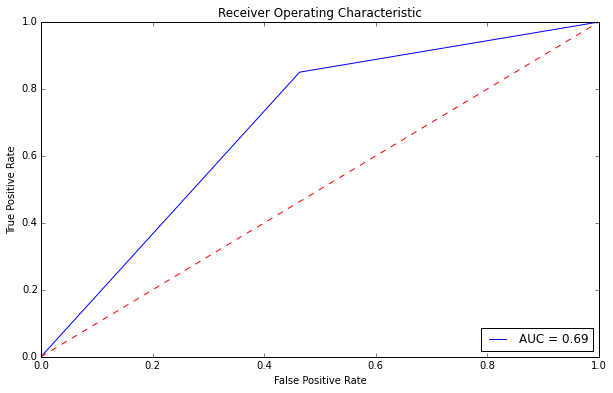

In [244]:
class_pred(graph=True)

### PCA

In [282]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

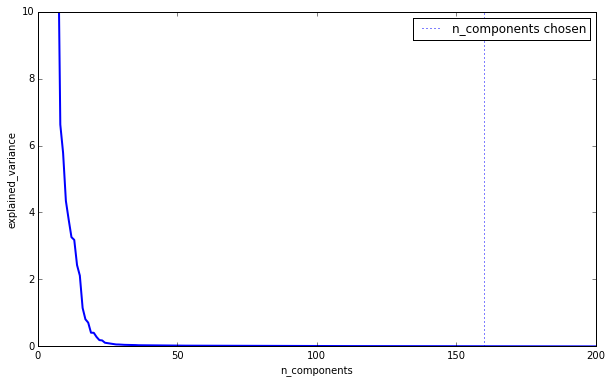

In [290]:
pca = PCA()
gbr = GradientBoostingRegressor(n_estimators=1000, max_depth=3, loss='huber',
                                max_features='log2', learning_rate=0.03)
pipe = Pipeline(steps=[('pca', pca), ('gbr', gbr)])

# Plot:
pca.fit(bXtest)

plt.clf()
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis([0, 200, 0, 10])
plt.xlabel('n_components')
plt.ylabel('explained_variance')

# Predict
n_components = [140, 150, 160]

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components))
estimator.fit(bXtest, bY)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [302]:
bXtest.shape

(2154, 218)

In [316]:
pca = PCA(n_components=160)
pca.fit(bXtest)
X = pca.transform(bXtest)

bX_train, bX_test, by_train, by_test = cross_validation.train_test_split(X, bY)
gbr = GradientBoostingRegressor(n_estimators=1000, max_depth=3, loss='huber',
                            max_features='log2', learning_rate=0.03)
gbr.fit(bX_train, by_train)

print_scores(gbr, X_test=bX_test, y_test=by_test)

R^2: 0.333976955134
RMSE: 36.497263911744135
MAE: 22.2778382959
MAPE: 6.86147338277
Error within 20: 0.454545454545
Pearson: (0.58105463380663858, 5.4634023778709484e-50)
